Quanvolutional Neural Networks 
==============================

Introduction
------------

### Classical convolution

**What are Convolutional Neural Networks?**

In computer science, Convolutional Neural Networks (CNNs) are a type of model mostly used to process images. They're really well suited for recognizing patterns in images, like shapes or objects.

**How do CNNs work?**

A CNN would break the image down into smaller pieces and then it would apply the same "filter" (or set of rules) to each piece. This filter helps the computer understand what's in each part of the image. The results from each piece of the image are then combined to create a new image-like object. This process is repeated multiple times, and the output is refined by other layers.
### Quantum convolution

We can extend the idea also to the context of quantum variational circuits:

1.  A small region of the input image, in our example a $2 \times 2$
    square, is embedded into a quantum circuit. In this demo, this is
    achieved with parametrized rotations applied to the qubits
    initialized in the ground state.
2.  A quantum computation, associated to a unitary $U$, is performed on
    the system. The unitary could be generated by a variational quantum
    circuit or, more simply, by a random circuit as proposed in this example.
3.  The quantum system is finally measured, obtaining a list of
    classical expectation values. The measurement results could also be
    classically post-processed as proposed in the reference material but, for
    simplicity, in this demo we directly use the raw expectation values.
4.  Analogously to a classical convolution layer, each expectation value
    is mapped to a different channel of a single output pixel.
5.  Iterating the same procedure over different regions, one can scan
    the full input image, producing an output object which will be
    structured as a multi-channel image.
6.  The quantum convolution can be followed by further quantum layers or
    by classical layers.

The main difference with respect to a classical convolution is that a
quantum circuit can generate highly complex kernels whose computation
could be, at least in principle, classically intractable.


### Thoughts

I think the above description of the algorithm is relevant for the rest of the notebook so I will keep it for reference.

First we import the necessary libraries:

In [10]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

Setting of the main hyper-parameters of the model
=================================================

We define the size of the train-test dataset, we specify the initial random seed, the number of epochs for training, number of layers and the `PREPROCESS` switch which enables the quantum preprocessing of the whole dataset. 

In [11]:
n_epochs = 30
n_layers = 1
n_train = 50
n_test = 30

SAVE_PATH = "./demonstration_assets/quanvolution/"
PREPROCESS = True
np.random.seed(0) 
tf.random.set_seed(0) 

Loading of the MNIST dataset
============================

We import the MNIST dataset from *Keras*. To accelerate the evaluation of this demo, we utilize a limited number of training and test images.


In [12]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

train_images = train_images / 255
test_images = test_images / 255

train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

Quantum circuit as a convolution kernel
=======================================

We use the structure introduced above as follows: first we define a device with $4$ qubits, then we define the circuit which will encode the classical input using rotations around the Y axis and after that will process the information through a random layer of quantum gates (based on the previously generated random parameters). The quantum circuit returns the expected values for each qubit (which will later become separated channels).

In [13]:
dev = qml.device("default.qubit", wires=4)

rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    RandomLayers(rand_params, wires=list(range(4)))

    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

The `quanv` function divides the image in squares of $3 \times 2$ pixels, process each square sequentially and each expectation value will be mapped to a different channel of the output image (which will have half of the initial resolution). 

In [14]:
def quanv(image):
    out = np.zeros((14, 14, 4))

    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

Quantum pre-processing of the dataset
=====================================

Applying the quantum convolution layer as a pre-processing step to the entire dataset is a best-effort choice since it avoids the need for reusing the quantum circuit while training. This allows for the classical model to be trained and evaluated directly on the pre-processed images.


In [15]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)

q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


We can further visualize the effect of the quantum preprocessing using the convolution layer:

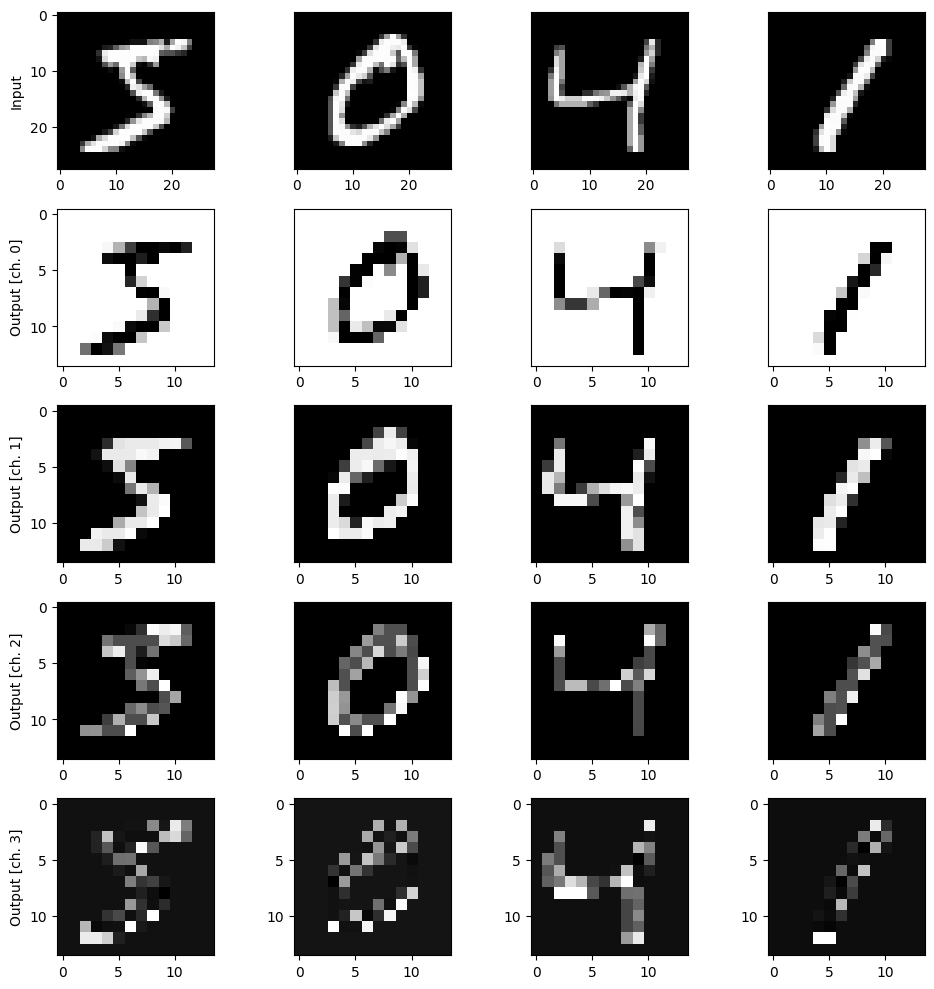

In [16]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

The downsampling of resolution and the local distortion are evident effects of the quantum kernel. However, the convolution layer successfully maintains the overall shape of the image, which aligns with our expectations.


Hybrid quantum-classical model
==============================

Following the application of the quantum convolution layer, the resultant features are input into a classical neural network. This network is designed to classify the ten distinct digits of the MNIST dataset. 

The architecture is straightforward: a single fully connected layer with ten output nodes, culminating in a softmax activation function. 
For compilation, the model employs a stochastic gradient descent optimizer and a cross-entropy loss function.

In [17]:
def MyModel():
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])
    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

Training
========

Initially, we instantiate the model, followed by training and validating it using the dataset pre-processed earlier through quantum convolution.


In [18]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 0s - 32ms/step - accuracy: 0.2200 - loss: 2.7953 - val_accuracy: 0.1000 - val_loss: 2.2825
Epoch 2/30
13/13 - 0s - 4ms/step - accuracy: 0.3000 - loss: 2.0951 - val_accuracy: 0.3333 - val_loss: 1.9802
Epoch 3/30
13/13 - 0s - 5ms/step - accuracy: 0.5800 - loss: 1.7071 - val_accuracy: 0.4333 - val_loss: 1.8523
Epoch 4/30
13/13 - 0s - 4ms/step - accuracy: 0.7000 - loss: 1.4083 - val_accuracy: 0.4667 - val_loss: 1.7286
Epoch 5/30
13/13 - 0s - 4ms/step - accuracy: 0.8000 - loss: 1.1744 - val_accuracy: 0.6000 - val_loss: 1.5986
Epoch 6/30
13/13 - 0s - 4ms/step - accuracy: 0.9000 - loss: 0.9747 - val_accuracy: 0.6333 - val_loss: 1.5104
Epoch 7/30
13/13 - 0s - 5ms/step - accuracy: 0.9200 - loss: 0.8193 - val_accuracy: 0.6000 - val_loss: 1.4417
Epoch 8/30
13/13 - 0s - 5ms/step - accuracy: 0.9200 - loss: 0.6938 - val_accuracy: 0.6000 - val_loss: 1.3782
Epoch 9/30
13/13 - 0s - 5ms/step - accuracy: 0.9600 - loss: 0.5920 - val_accuracy: 0.6333 - val_loss: 1.3263
Epoch 10/30
13/13 

To compare the outcomes with and without the quantum convolution layer, we also initialize a "classical" version of the model to be trained and validated directly on the raw MNIST images, that is, without the quantum pre-processing stage.


In [19]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 0s - 29ms/step - accuracy: 0.0200 - loss: 2.4681 - val_accuracy: 0.1667 - val_loss: 2.1675
Epoch 2/30
13/13 - 0s - 4ms/step - accuracy: 0.2400 - loss: 2.0399 - val_accuracy: 0.4000 - val_loss: 1.9833
Epoch 3/30
13/13 - 0s - 5ms/step - accuracy: 0.4800 - loss: 1.7407 - val_accuracy: 0.6333 - val_loss: 1.8287
Epoch 4/30
13/13 - 0s - 5ms/step - accuracy: 0.7400 - loss: 1.4948 - val_accuracy: 0.6333 - val_loss: 1.6972
Epoch 5/30
13/13 - 0s - 5ms/step - accuracy: 0.8400 - loss: 1.2884 - val_accuracy: 0.6333 - val_loss: 1.5872
Epoch 6/30
13/13 - 0s - 5ms/step - accuracy: 0.9200 - loss: 1.1154 - val_accuracy: 0.6333 - val_loss: 1.4967
Epoch 7/30
13/13 - 0s - 4ms/step - accuracy: 0.9200 - loss: 0.9707 - val_accuracy: 0.6667 - val_loss: 1.4223
Epoch 8/30
13/13 - 0s - 5ms/step - accuracy: 0.9600 - loss: 0.8497 - val_accuracy: 0.6667 - val_loss: 1.3609
Epoch 9/30
13/13 - 0s - 4ms/step - accuracy: 0.9600 - loss: 0.7482 - val_accuracy: 0.7000 - val_loss: 1.3096
Epoch 10/30
13/13 

Results
=======

We can finally plot the test accuracy and the test loss with respect to
the number of training epochs.


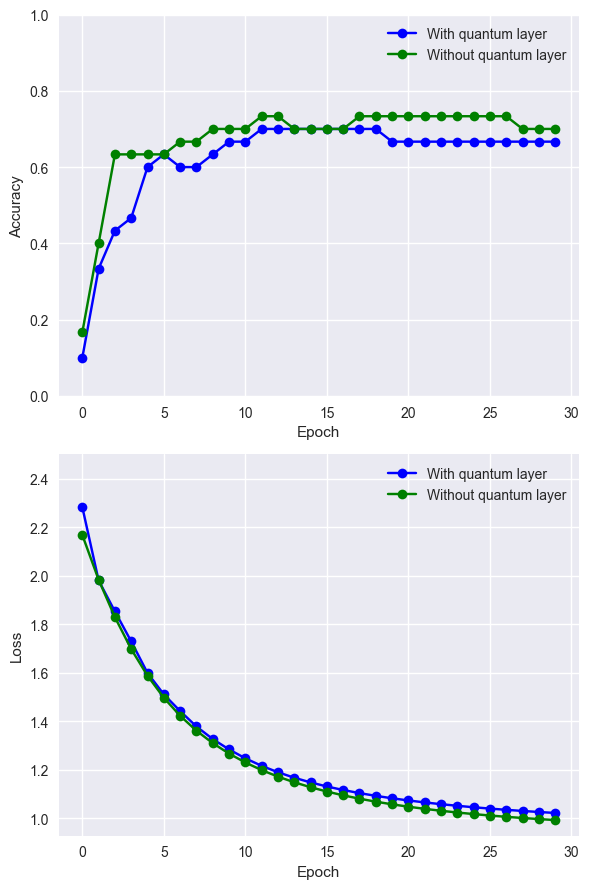

In [20]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()